# SDK use

The Intel® Geti™ SDK is a python package which contains tools to interact with an Intel® Geti™ server via the REST API. It provides functionality for:

- Project creation from annotated datasets on disk
- Project downloading (images, videos, configuration, annotations, predictions and models)
- Project creation and upload from a previous download
- Deploying a project for local inference with OpenVINO
- Getting and setting project and model configuration
- Launching and monitoring training jobs
- Media upload and prediction

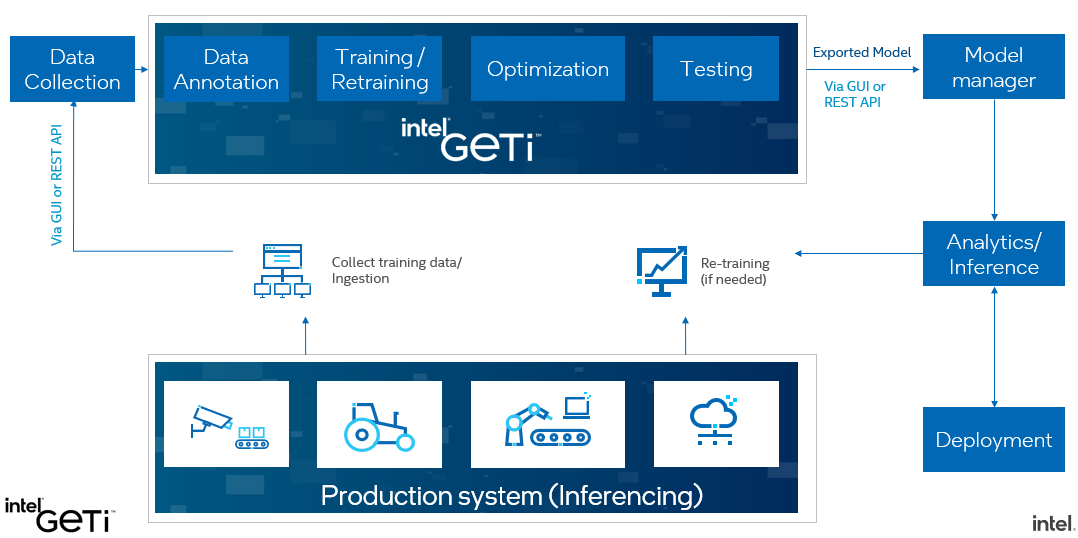

# How to digest new production data into the Intel Geti platform?

In this case we will use a webcam video, you can ***CHALLENGE TO THE AUDIENCE*** (for example: Where is my apple? Where is my cup? Simple Challenges to the audiences. The goal here is to push different acquisition conditions, lighting, camera, backgrounds, to show how flexible is the platform and how eficient will be the models. 

- Open GUI and check the platform before running this notebook
- Record the video
- Upload the video to Intel Geti platform
- Open the GUI
- Edit annotation with this new video (Show this)
- Download the deployment (active model)

# Uploading a video to the platform, and requesting a prediction for it
In this notebook, we will upload a single numpy image to a specific project on the platform, and make a request to get a prediction for it

In [6]:
# As usual we will connect to the platform first, using the server details from the .env file

from geti_sdk import Geti
from geti_sdk.utils import get_server_details_from_env

hostname, authentication_info = get_server_details_from_env()
verify_certificate=False
geti = Geti(host=hostname, **authentication_info)


2022-12-07 14:31:50,317 - INFO - Personal access token validated on host https://10.91.120.185


### Setting up the project client, video client and prediction client
In this notebook, we will need three client objects: A ProjectClient to retrieve the project we want to upload to, an VideoClient to be able to upload the image and a PredictionClient to request and receive the prediction for the image. We first set up the ProjectClient, since we will need to get the project we are interested in before we can initialize the other two clients.

In [7]:
from geti_sdk.rest_clients import PredictionClient, ProjectClient, VideoClient

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)

Now that the project client is set up, we need to specify the project we would like to upload to. We will use the `where_is_my_apple demo`

In [8]:
projects = project_client.list_projects()

4 projects were found on the platform:

 Project: AMR Detection in Warehouse - trained
  Task 1: Detection task
    Labels: ['AMR', 'No Object']


 Project: AMR Detection in Warehouse - untrained
  Task 1: Detection task
    Labels: ['AMR', 'No Object']


 Project: Bolts Segmentation - Anomaly
  Task 1: Anomaly segmentation task
    Labels: ['Normal', 'Anomalous']


 Project: bolt_detection
  Task 1: Detection task
    Labels: ['good', 'bad', 'No Object']




In [4]:
PROJECT_NAME = "AMR Detection in Warehouse - untrained"

With the project name specified, we can retrieve the project details from the project client and use the returned `Project` object to set up an `video_client` and `prediction_client` for this project.

In [5]:
project = project_client.get_project_by_name(PROJECT_NAME)
video_client = VideoClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)
prediction_client = PredictionClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)

## Uploading an video
The SDK contains an example image that we can grab and upload to the project. The path to the image is in the `EXAMPLE_IMAGE_PATH` constant, from the `geti_sdk.demos` module. We can upload the image directly from file using the `image_client.upload_image()` method. Before uploading, we can get a list of all images in the project, so that we can verify that the image was uploaded successfully

In [ ]:
videos = video_client.get_all_videos()
print(f"Project '{project.name}' contains {len(videos)} videos.")

Now, we will upload the example image from the SDK. Of course, you can replace the `EXAMPLE_IMAGE_PATH` with a path to one of your own images as well.

In [ ]:
#VIDEO_PATH = "C:/Users/paularam/OneDrive - Intel Corporation/Pictures/Camera Roll/WIN_20221024_08_17_18_Pro.mp4"
VIDEO_PATH = "C:/Users/paularam/OneDrive - Intel Corporation/Pictures/Camera Roll/WIN_20221024_08_18_26_Pro.mp4"

#from geti_sdk.demos import VIDEO_PATH

video = video_client.upload_video(video=VIDEO_PATH)

Let's fetch the list of images again and see if it has changed

In [ ]:
videos = video_client.get_all_videos()
print(f"Project '{project.name}' contains {len(videos)} images.")

## Go to the GUI to see/edit the annotations
Once you upload the new production data, you should open the GUI and check, approve or edit the annotations. When the model is ready you can download the deployment and run it locally or run the inference in the platform. In this example we will download the deployment and run it locally.

## Download the model and run de deployment locally
Before deploying, we need to make sure that the project is trained. Otherwise it will not contain any models to deploy, and the deployment will fail.

In [ ]:
from geti_sdk.demos import ensure_trained_example_project

ensure_trained_example_project(geti=geti, project_name=PROJECT_NAME);

Once we are sure that the project has trained models for each task, we can create the deployment in the cell below.

In [ ]:
deployment = geti.deploy_project(project_name=PROJECT_NAME)

## Saving the deployment
When we create the deployment, the model data is saved to a temporary folder. We store the deployment for offline re-use later on by saving it: This will copy the model data from the temporary folder to the path we specify. If we want to run inference locally again, we can simply reload the deployment from the saved folder, without having to connect to the platform again.

In [ ]:
import os

PATH_TO_DEPLOYMENT_FOLDER = os.path.join("deployments", PROJECT_NAME)

deployment.save(path_to_folder=PATH_TO_DEPLOYMENT_FOLDER)